# Advanced Lane Finding
***


In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project. 

## The Project

The goals / steps of this project are the following:

-  Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
-  Apply a distortion correction to raw images.
-  Apply a perspective transform to rectify binary image ("birds-eye view").
-  Use color transforms, gradients, etc., to create a thresholded binary image.
-  Detect lane pixels and fit to find the lane boundary.
-  Determine the curvature of the lane and vehicle position with respect to center.
-  Warp the detected lane boundaries back onto the original image.
-  Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# All imports necessary for the project.

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Step 1: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

(720, 1280, 3)


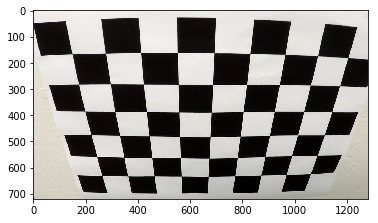

In [2]:
# Reading in a calibration image to test.

img = mpimg.imread('camera_cal/calibration2.jpg')
plt.imshow(img)
print(img.shape)

In [3]:
#Read in and make a list of calibration images. 
# Use glob to get the list of files in a directory

images = glob.glob('camera_cal/calibration*.jpg')

def displayImages(images, cols = 4, rows = 5, size = (16, 9), cmap=None):
    '''
    Display images in a grid
    '''
    
    number_of_images = len(images)
    
    figure, axes = plt.subplots(rows, cols, figsize = size)
    indices = range(cols * rows)
    figure.subplots_adjust(hspace = 0.8)
    
    for ax, index in zip(axes.flat, indices):
        if index < number_of_images:
            img = mpimg.imread(images[index])
            ax.imshow(img, cmap=cmap)
            ax.set_title(images[index])

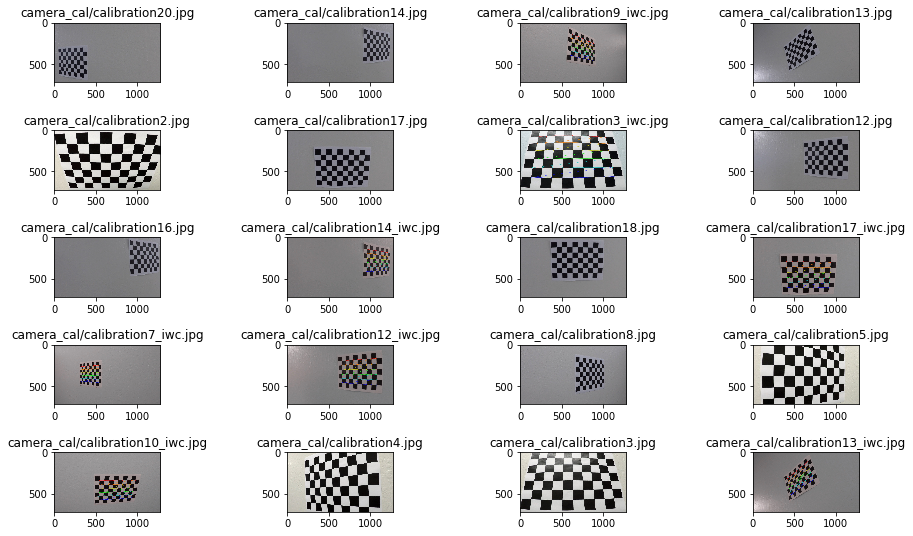

In [4]:
# Display images before calibration

displayImages(images)

### Obtain image points and object points for camera calibration.

In [5]:
# Arrays to store object points and image points from all the images

def getImageAndObjectPoints(images):
    objpoints = [] # 3D points in the real world space
    imgpoints = [] # 2D points in the image plane

    #Prepare object points, like (0, 0, 0), (1, 0, 0), (2, 0, 0), ... , (8, 5, 0)

    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x, y coordinates

    for image, index in zip(images, range(len(images))):

        # read each image
        img = cv2.imread(image)

        # Convert image to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

            # Save images with corners with 'iwc_' prefix
            cv2.imwrite(( (images[index]).split('/')[0]+ '/' + 'iwc_' + (images[index]).split('/')[1] ), img)
    return objpoints, imgpoints

In [6]:
objpoints, imgpoints = getImageAndObjectPoints(images)

### Display images with corners

In [7]:
images_with_corners = glob.glob('camera_cal/iwc_calibration*.jpg')

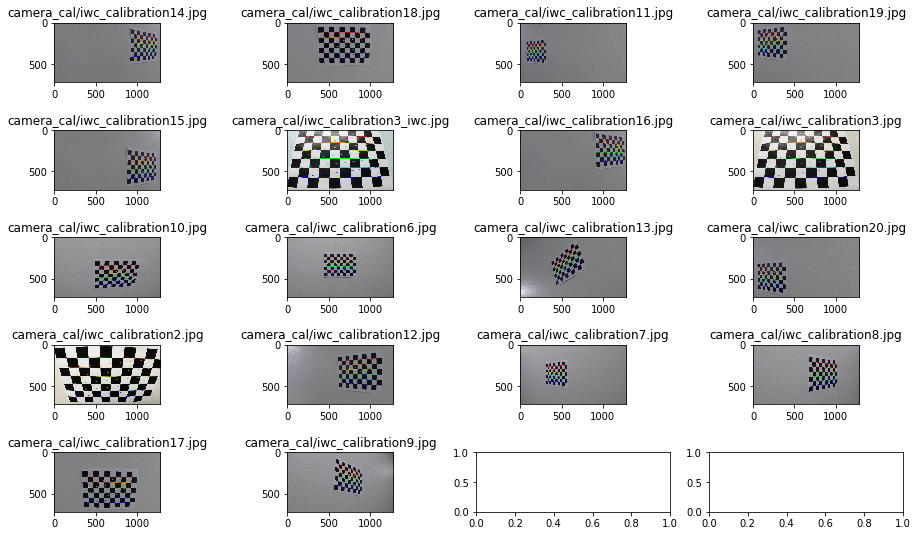

In [8]:
# Display images with corners
# The empty images mean that those images doesn't have the specified chessboard corners
displayImages(images_with_corners)

### Calibrate the camera and obtaining the matrix and distortion coefficients

In [9]:
img = cv2.imread(images[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1] , None, None)

## Step 2: Apply a distortion correction to raw images

In [10]:
# Applying the distortion and matrix coefficients to samples images

undst = cv2.undistort(img, mtx, dist, None, mtx)

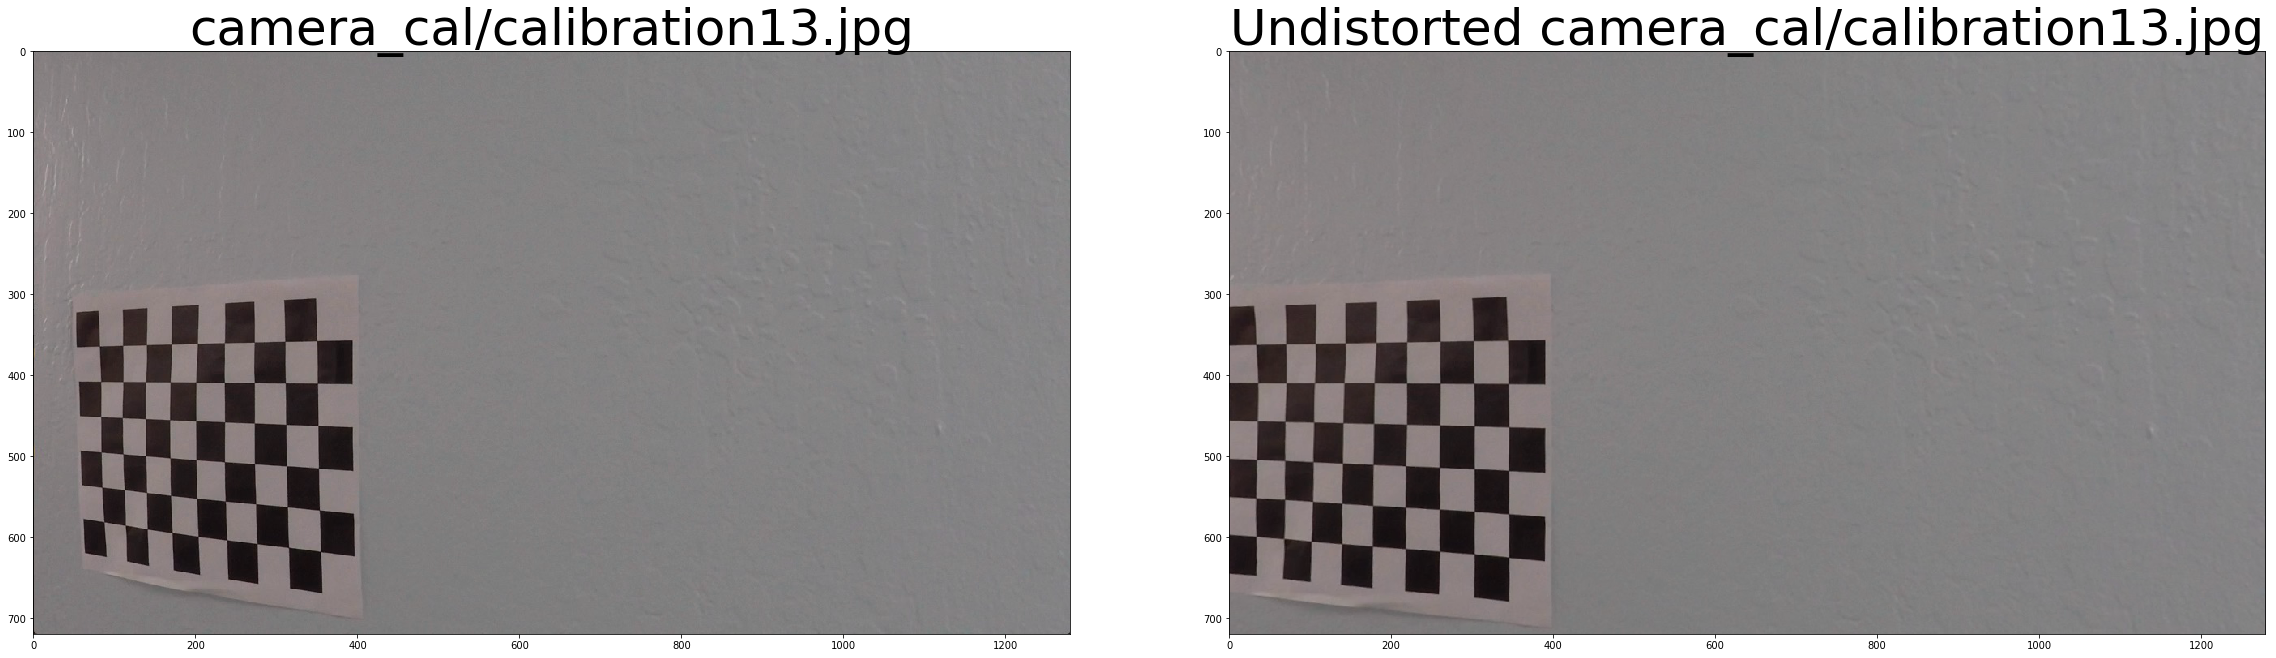

In [11]:
# Displaying the undistorted image.

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title(images[3], fontsize=50)
ax2.imshow(undst)
ax2.set_title('Undistorted ' + images[3], fontsize=50)
plt.subplots_adjust(left=0., right=2, top=0.9, bottom=0.)

### Test images

In [12]:
testImages = glob.glob('test_images/*.jpg')

In [13]:
print((testImages))

['test_images/straight_lines1.jpg', 'test_images/test1.jpg', 'test_images/test6.jpg', 'test_images/straight_lines2.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg']


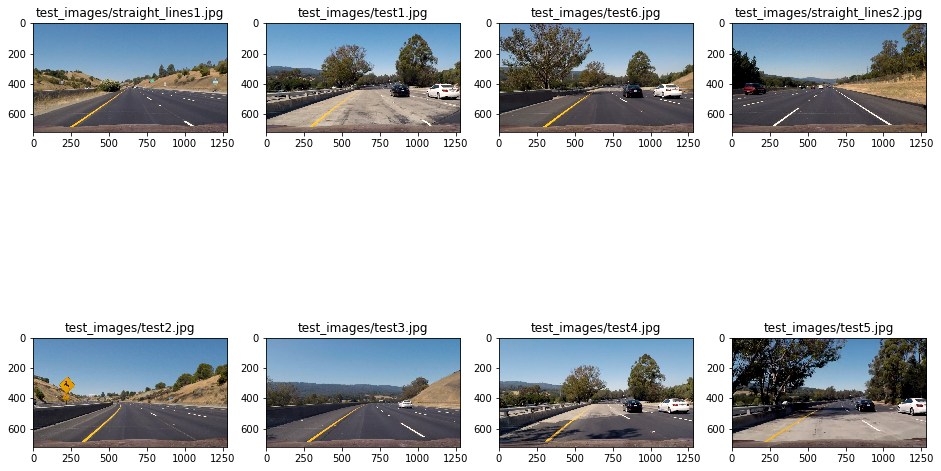

In [14]:
displayImages(testImages, cols = 4, rows = 2)

## steps to calculate lane curvature

Masking and thsholding techniques

perspective transform to get the birds eye view


extract the curvature by applying polynomial f(y) = A * y ** 2 + B * y + C




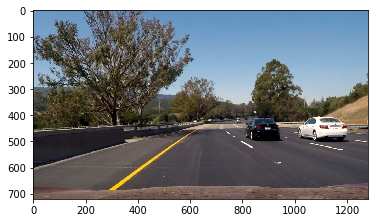

In [15]:
img = mpimg.imread('test_images/test6.jpg')
plt.imshow(img)

In [16]:
# undistort image using camera calibration matrix from above
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

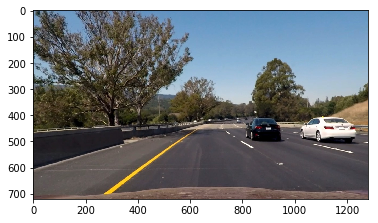

In [17]:
undist = undistort(img, mtx, dist)
plt.imshow(undist)

## Step 3: Apply a perspective transform to rectify binary image ("birds-eye view").

In [18]:
# function to take in an undistorted image and do perspective transform and warp

def transform_and_warp(image, src, dst):
    
    img_size = (image.shape[1], image.shape[0])
    
    # a) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # b) use cv2.getPerspectiveTransform() to get inverse of M, the transform matrix

    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # c) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

In [19]:
# Calculate the height and weight of the sameple image
h = img.shape[0]
w = img.shape[1]

# Determining the camera viewpoint in a lane.

src = np.float32([(570,464),
                  (714,464), 
                  (244,675), 
                  (1064,675)])
dst = np.float32([(250,0),
                  (w-250,0),
                  (250,h),
                  (w-250,h)])


### Apply undistort and perspective transform

In [20]:
undistorted_image = undistort(img, mtx, dist)
top_down, M, Minv = transform_and_warp(undistorted_image, src, dst)

### Visualize warped image.

Text(0.5,1,'top_down/warped Image')

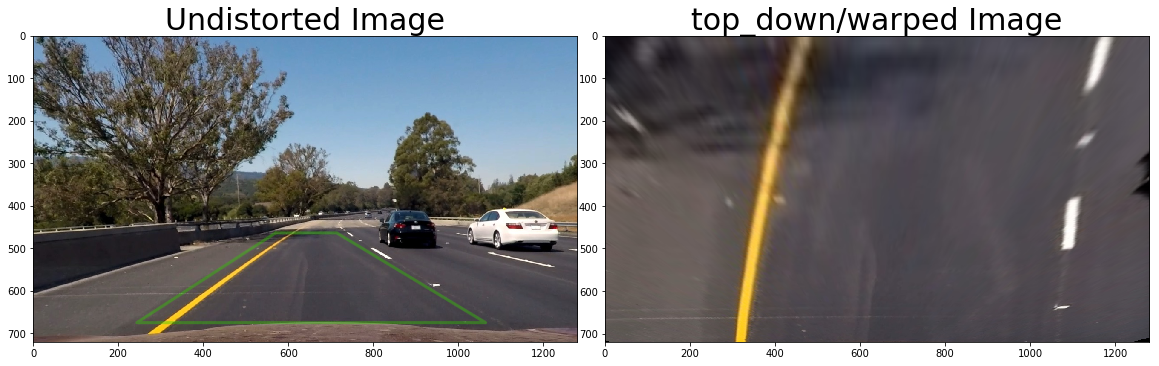

In [21]:
# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undistorted_image)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc00', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(top_down)
ax2.set_title('top_down/warped Image', fontsize=30)

## Step 4: Use color transforms, gradients, etc., to create a thresholded binary image.

In [22]:
def abs_sobel_thresh(img, orient='x', kernel_size = 3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel_size))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel_size))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

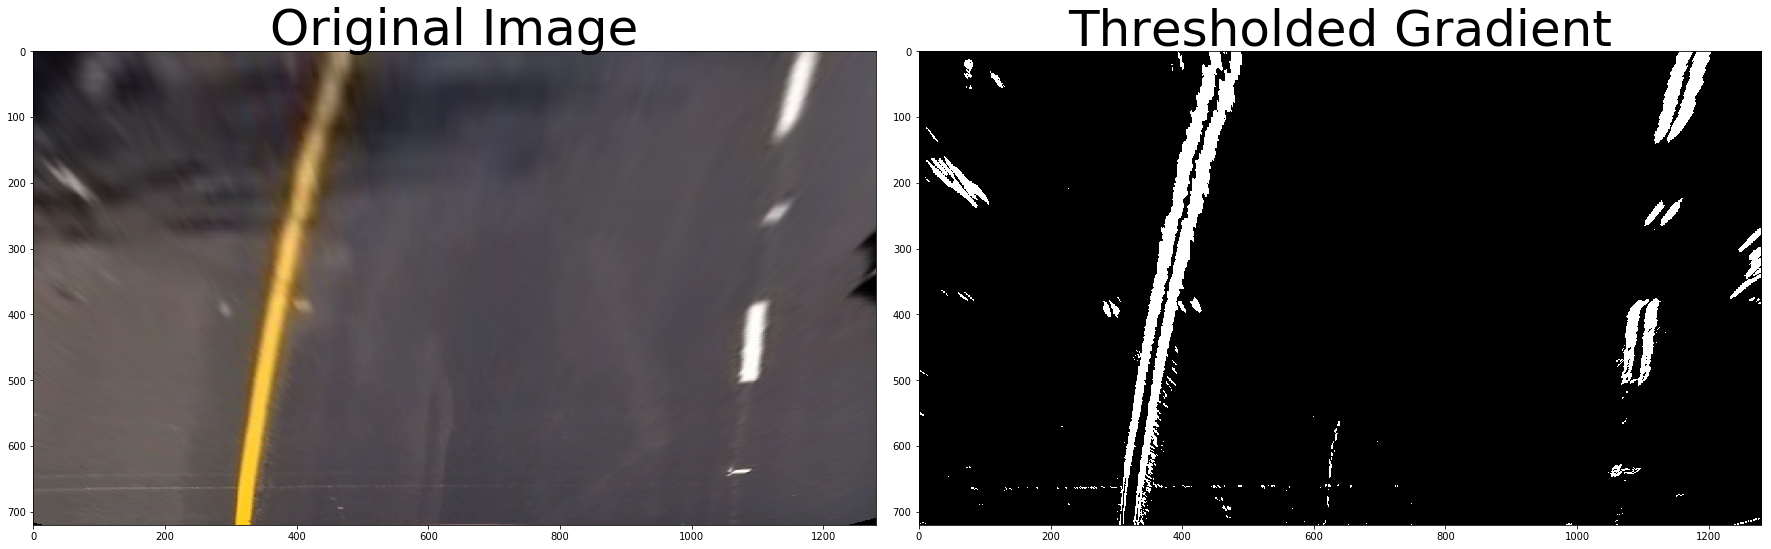

In [23]:
top_down_grad_binary = abs_sobel_thresh(top_down, orient='x', thresh_min=15, thresh_max=150)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(top_down)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down_grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

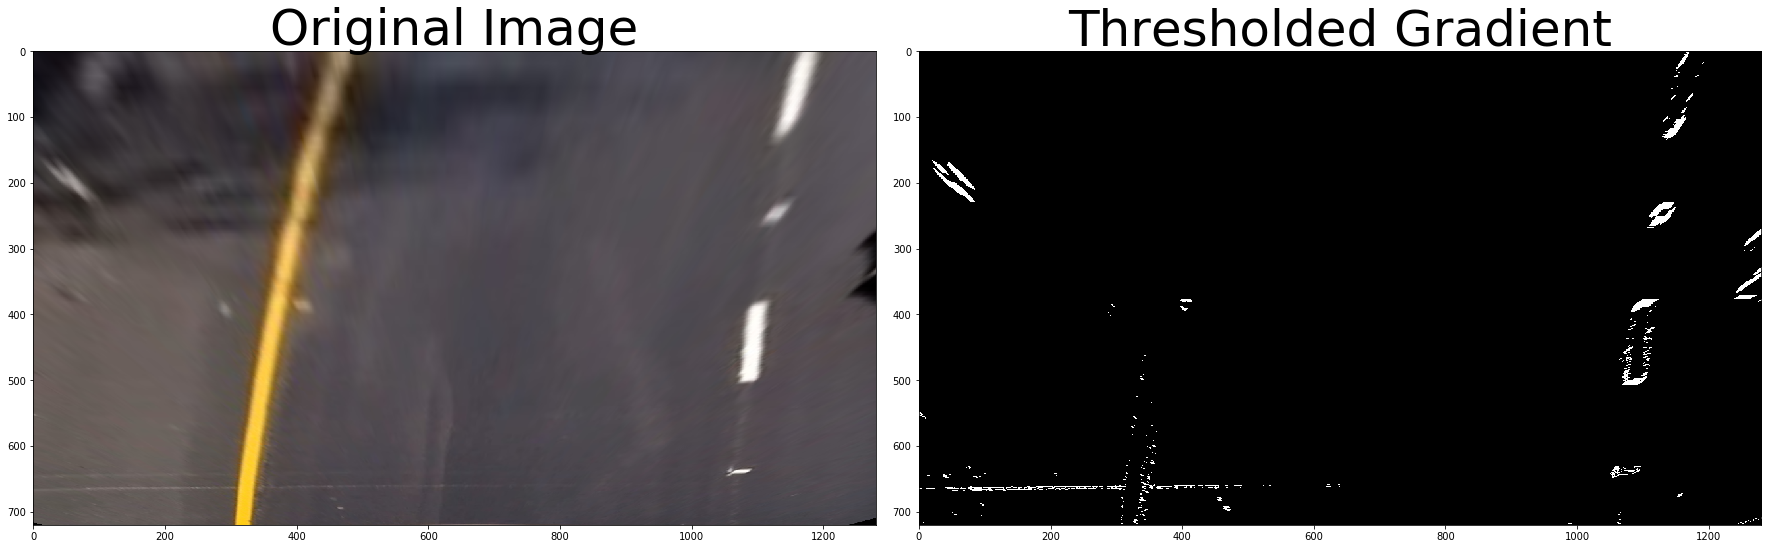

In [24]:
top_down_grad_binary_y = abs_sobel_thresh(top_down, orient='y', thresh_min=15, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(top_down)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down_grad_binary_y, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [25]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

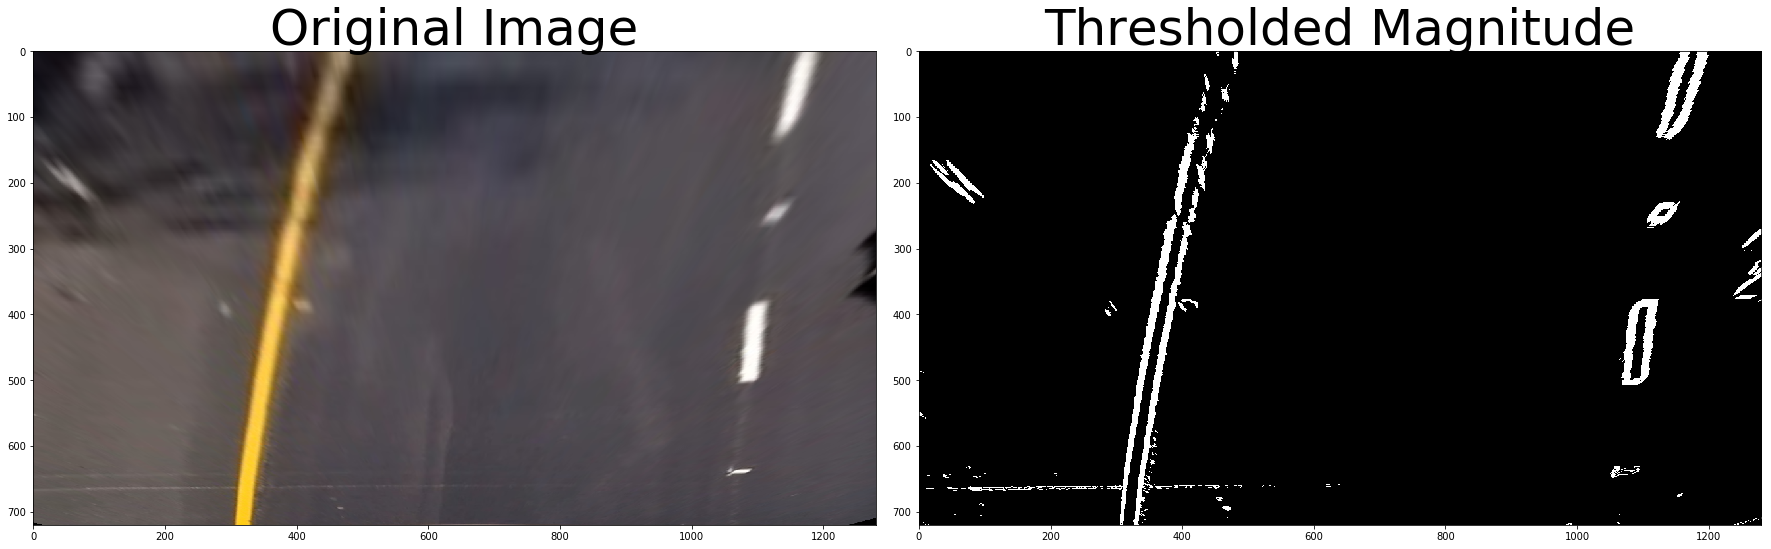

In [26]:
# Run the function
top_down_mag_binary = mag_thresh(top_down, sobel_kernel=3, mag_thresh=(15, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(top_down)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down_mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [27]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

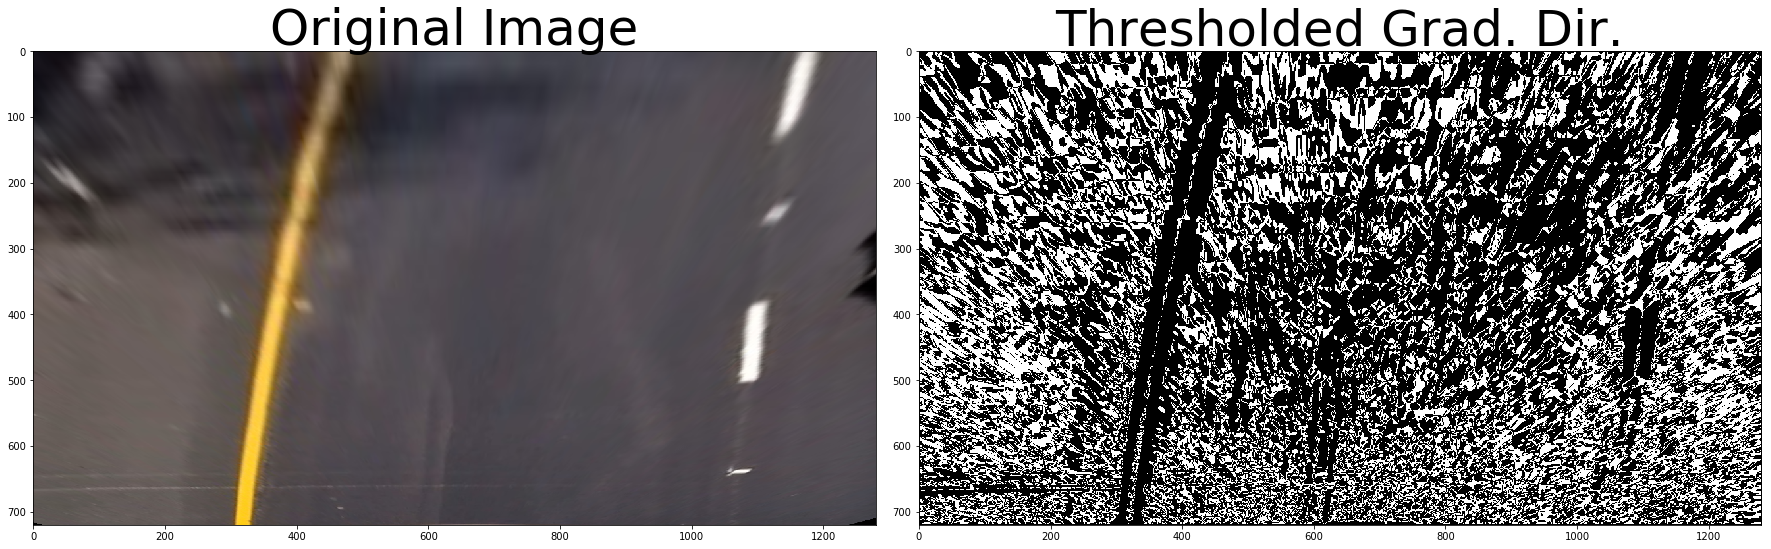

In [28]:
# Run the function
top_down_dir_binary = dir_threshold(top_down, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(top_down)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down_dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [29]:
ksize = 3

In [30]:
gradx = abs_sobel_thresh(top_down, orient='x', thresh_min=17, thresh_max=150, kernel_size = ksize)
grady = abs_sobel_thresh(top_down, orient='y', thresh_min=17, thresh_max=150, kernel_size = ksize)
mag_binary = mag_thresh(top_down, sobel_kernel=ksize, mag_thresh=(15, 100))
dir_binary = dir_threshold(top_down, sobel_kernel=ksize, thresh=(0, np.pi/2))

In [31]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[((gradx == 1))] = 1


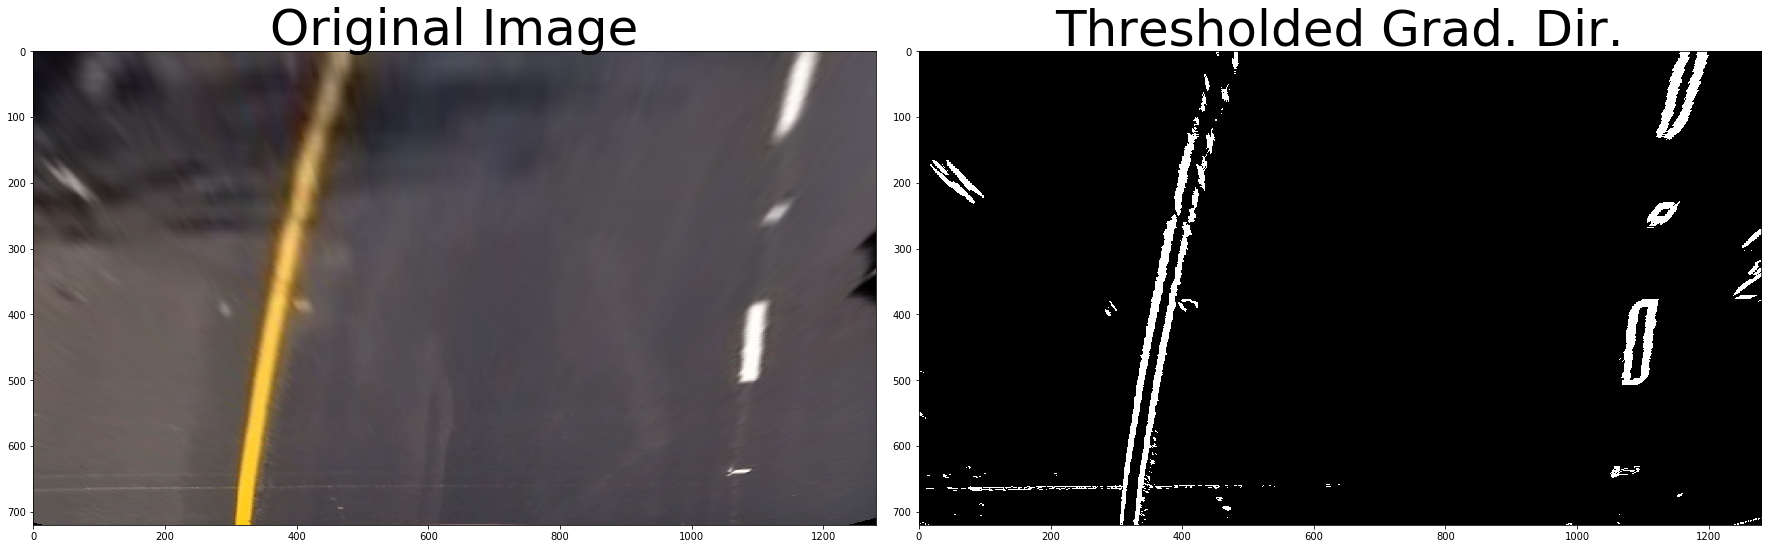

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(top_down)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [33]:
#image = mpimg.imread(top_down)
thresh = (180, 255)
gray = cv2.cvtColor(top_down, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

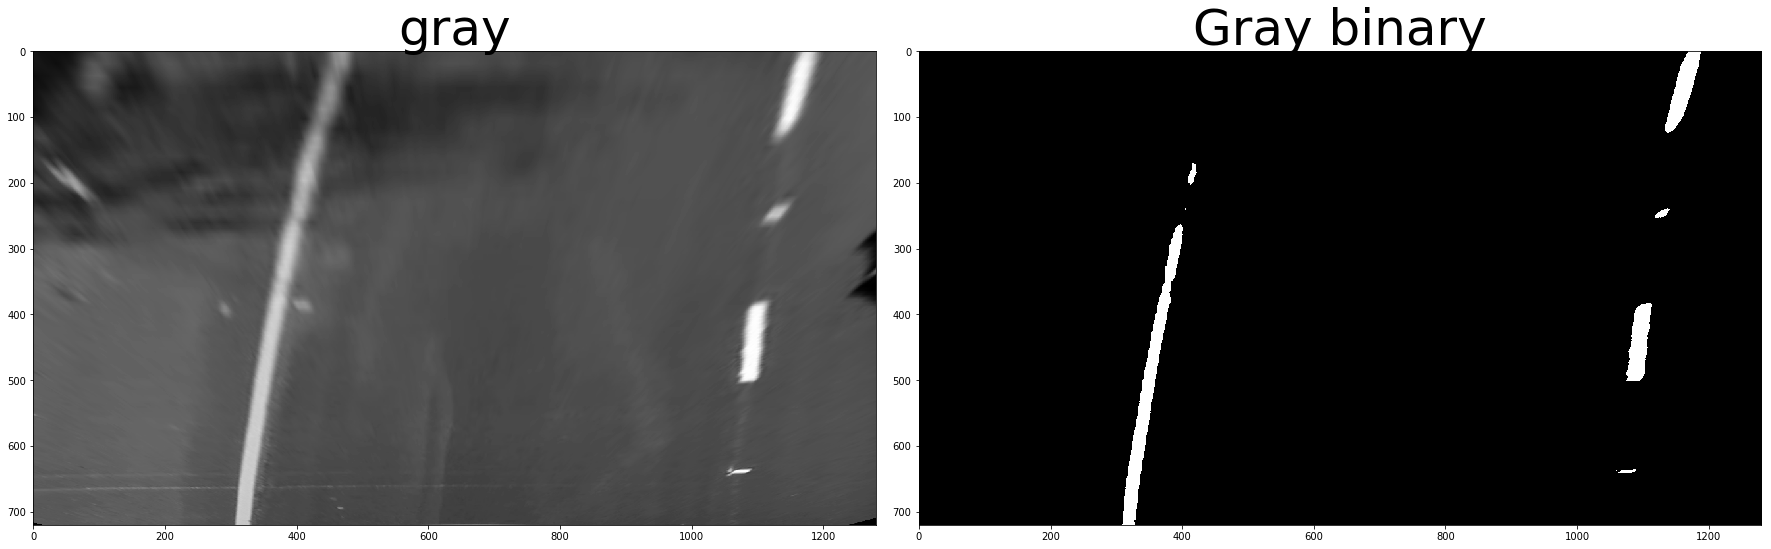

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gray, cmap='gray')
ax1.set_title('gray', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Gray binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [35]:
R = top_down[:,:,0]
G = top_down[:,:,1]
B = top_down[:,:,2]


thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1

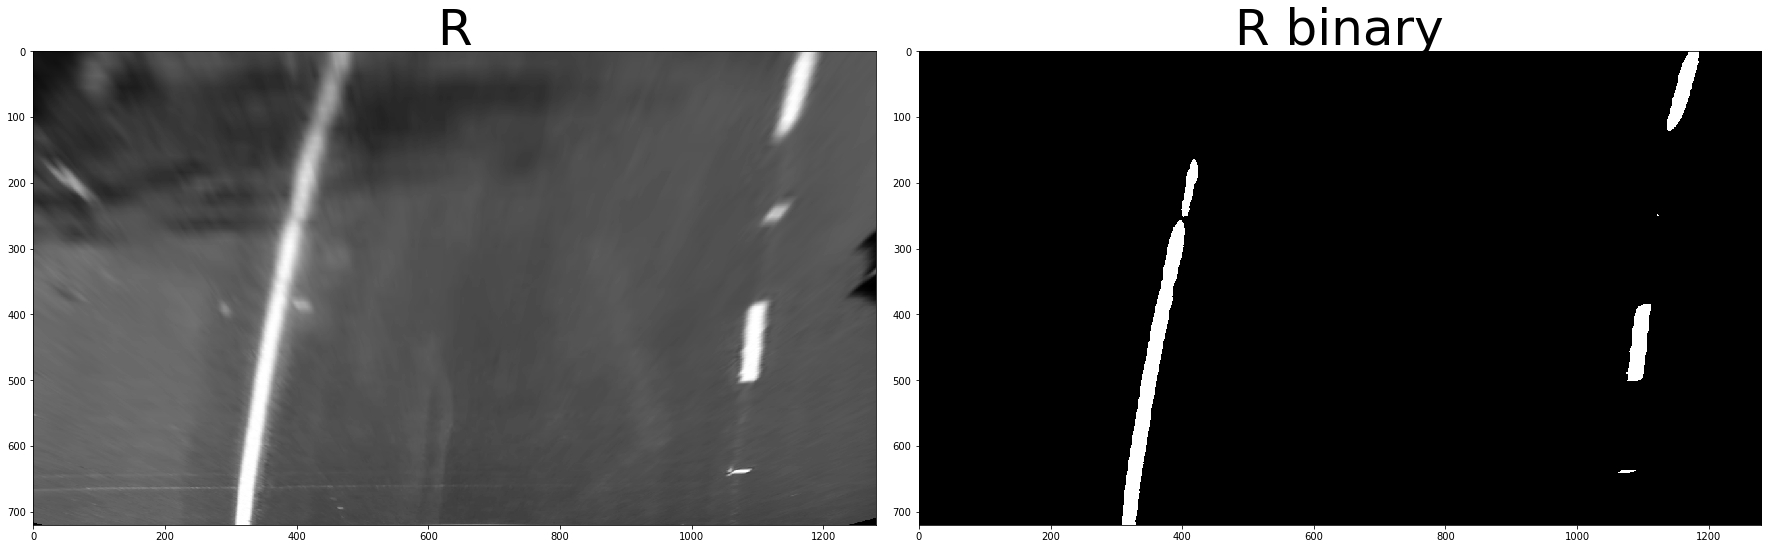

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(R, cmap='gray')
ax1.set_title('R', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('R binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [37]:
hls = cv2.cvtColor(top_down, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

In [38]:
thresh = (100, 255)
s_binary = np.zeros_like(S)
s_binary[(S > thresh[0]) & (S <= thresh[1])] = 1

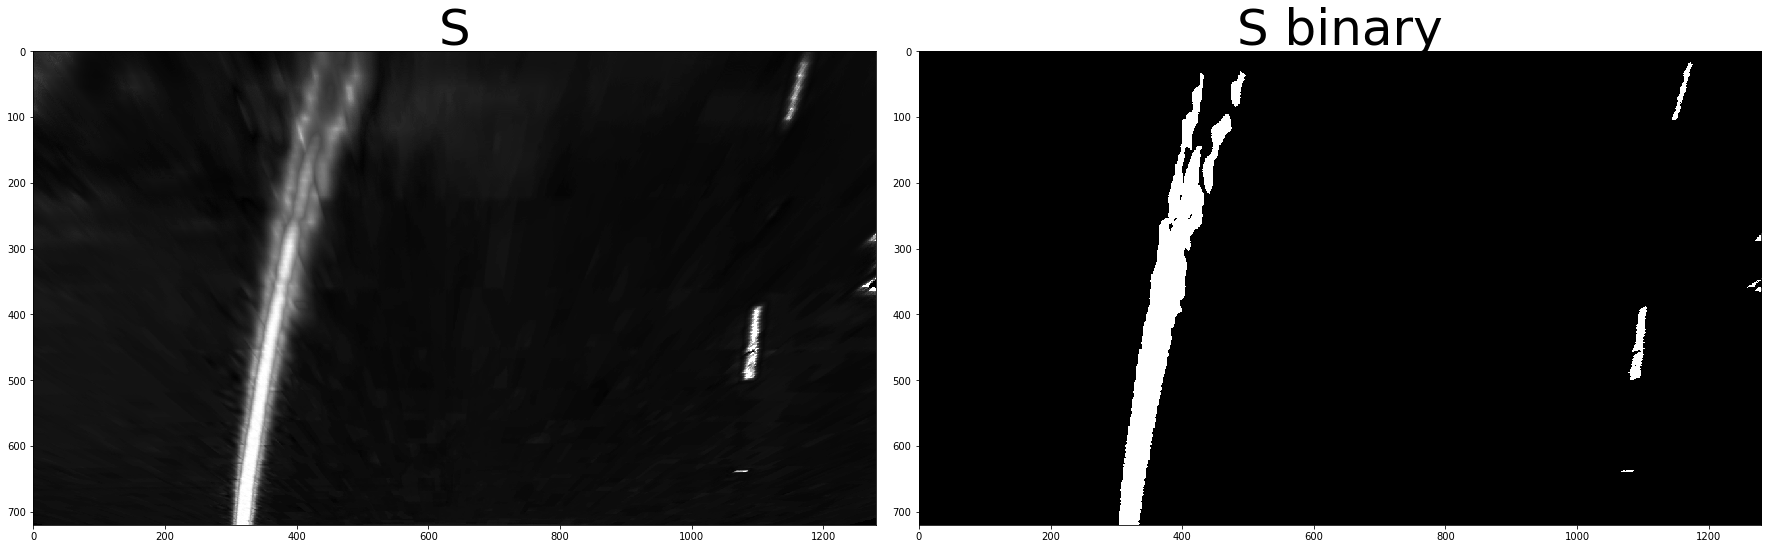

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(S, cmap='gray')
ax1.set_title('S', fontsize=50)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('S binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [40]:
thresh = (14, 100)
h_binary = np.zeros_like(H)
h_binary[(H > thresh[0]) & (H <= thresh[1])] = 1

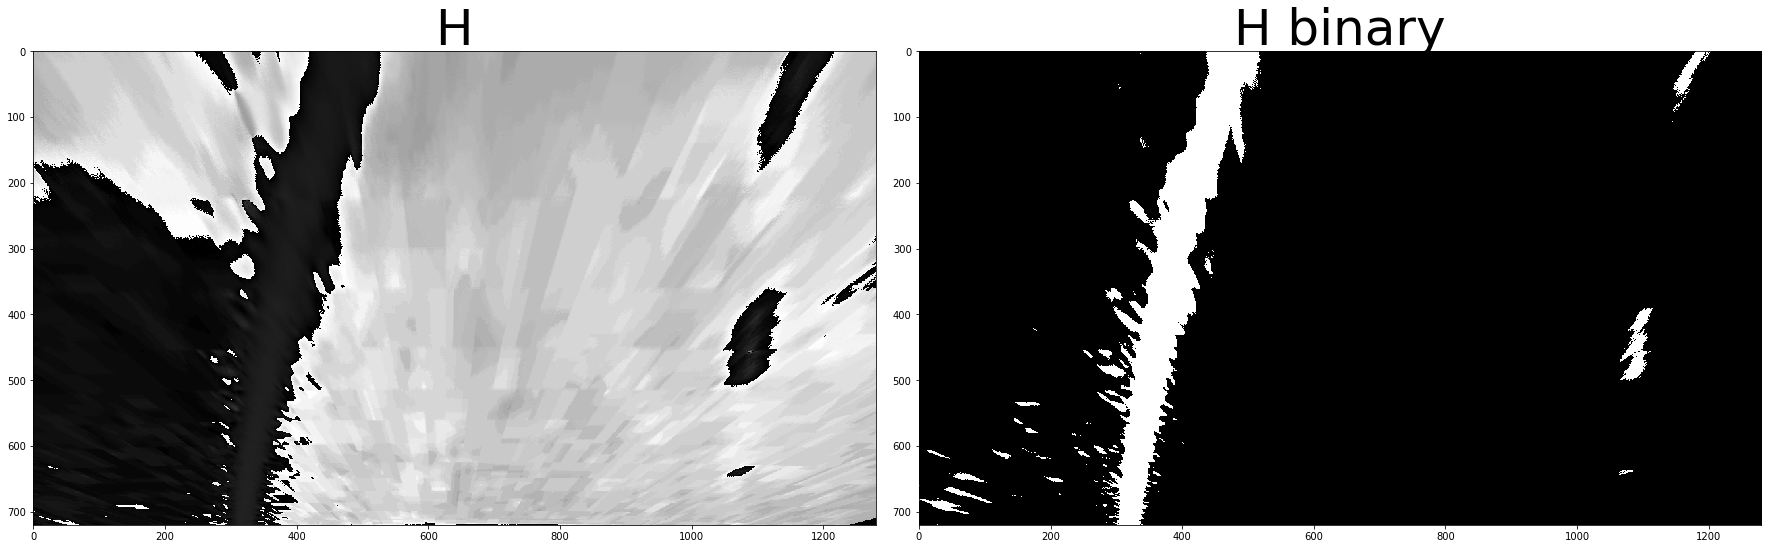

In [41]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H, cmap='gray')
ax1.set_title('H', fontsize=50)
ax2.imshow(h_binary, cmap='gray')
ax2.set_title('H binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [42]:
thresh = (195, 255)
l_binary = np.zeros_like(L)
l_binary[(L > thresh[0]) & (L <= thresh[1])] = 1

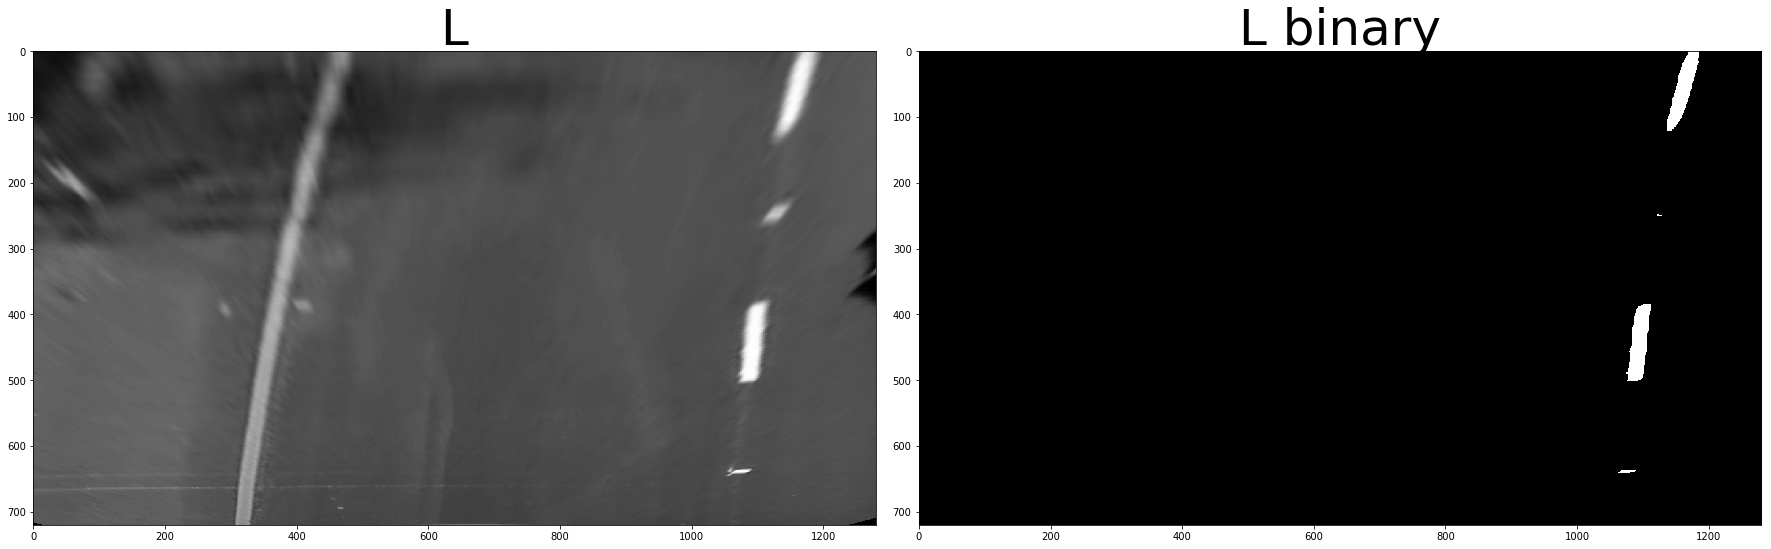

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(L, cmap='gray')
ax1.set_title('L', fontsize=50)
ax2.imshow(l_binary, cmap='gray')
ax2.set_title('L binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [44]:
combined = np.zeros_like(dir_binary)
combined[((s_binary == 1) & (h_binary == 1)) | ((l_binary == 1))] = 1

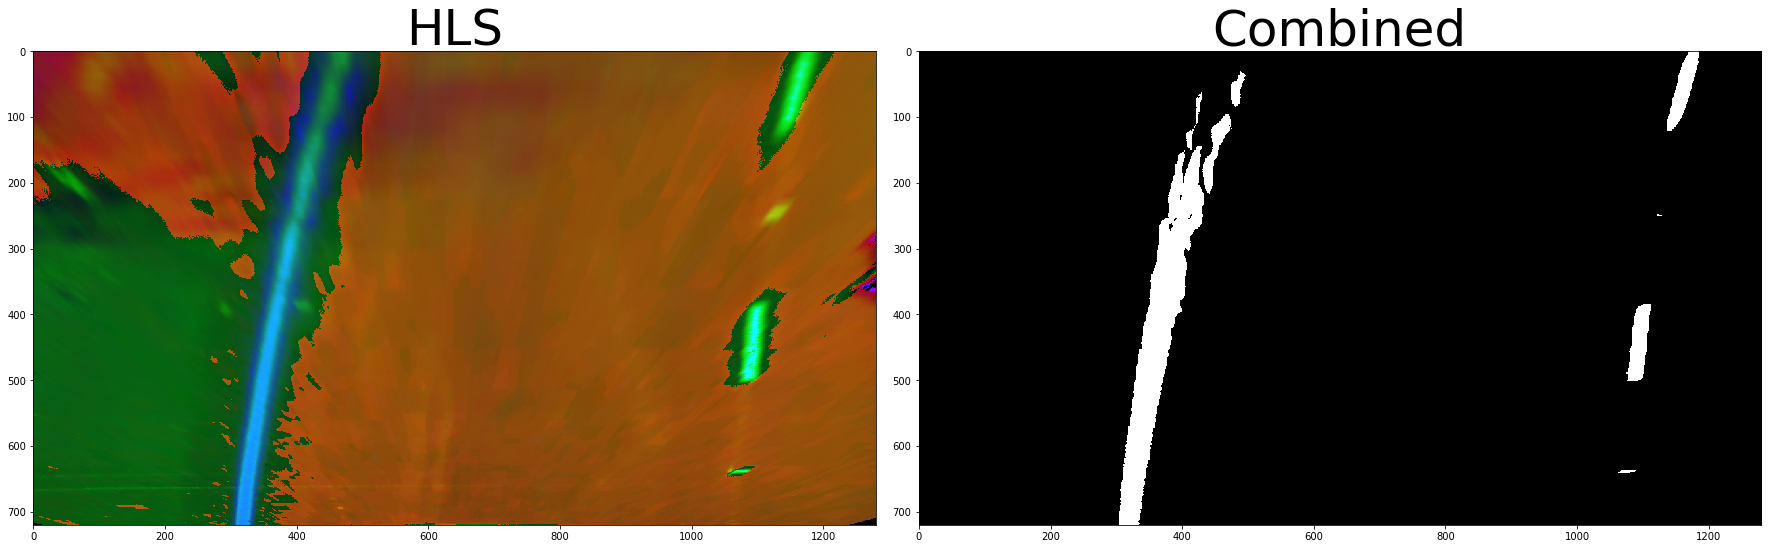

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(hls, cmap='gray')
ax1.set_title('HLS', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [46]:
def h_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,0]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [47]:
def l_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,1]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [48]:
def s_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

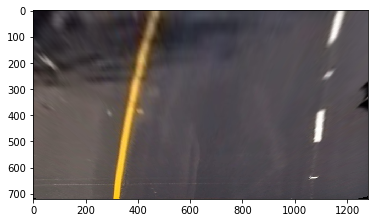

In [49]:
plt.imshow(top_down)

#### Based on the results in the above tests we write a function to create a binary image. Multiple combinations have been tested but finally settled down to use gradient x, magnitude, s and h values.

In [50]:
# warped is the top_down view of the transformed lanes

def makeBinary(top_down1, s_thresh=(140, 255), sx_thresh=(20, 120)):
    RGB_img = cv2.cvtColor(top_down1, cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(RGB_img, cv2.COLOR_RGB2HLS)

    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Since there is not meaningful information from individual plots we are only
    # considering the gradient x and the magnitude threshold to create binary
    
    sxbinary = abs_sobel_thresh(top_down1, orient='x', thresh_min=20, thresh_max=120)
    mag_binary = mag_thresh(top_down1, sobel_kernel=3, mag_thresh=(17, 150))

    # For the color, I'm using all three h, l and s channel as below.
    
    h_binary = h_select(top_down1, thresh=(10, 100))
    l_binary = l_select(top_down1, thresh=(185, 255))
    s_binary = s_select(top_down1, thresh=(100, 255))
    
    '''# Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1'''
    
    
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    all_hls_binary = np.zeros_like(sxbinary)
    #all_hls_binary[((s_binary == 1) & (h_binary == 1)) | (l_binary == 1)] = 1
    all_hls_binary[((s_binary == 1) & (h_binary == 1))] = 1

    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    #combined_binary[(hls_binary == 1)] = 1
    combined_binary[(all_hls_binary == 1) | (sxbinary == 1) | (mag_binary == 1)] = 1
    
    return combined_binary

### Testing the actions taken so far in the pipeline function below.

In [51]:
def pipeline(binary_image):
    copy_binary_image = np.copy(binary_image)
    # Convert to HLS color space and separate the V channel

    
    undistorted_image = undistort(copy_binary_image, mtx, dist)
    top_down2, M, Minv = transform_and_warp(undistorted_image, src, dst)
    combined_binary_image = makeBinary(top_down2)
    
    return combined_binary_image

In [52]:
testImages = glob.glob('test_images/*.jpg')
test_image = mpimg.imread('test_images/test1.jpg')
print(testImages)

combined_binary = pipeline(test_image)

['test_images/straight_lines1.jpg', 'test_images/test1.jpg', 'test_images/test6.jpg', 'test_images/straight_lines2.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg']


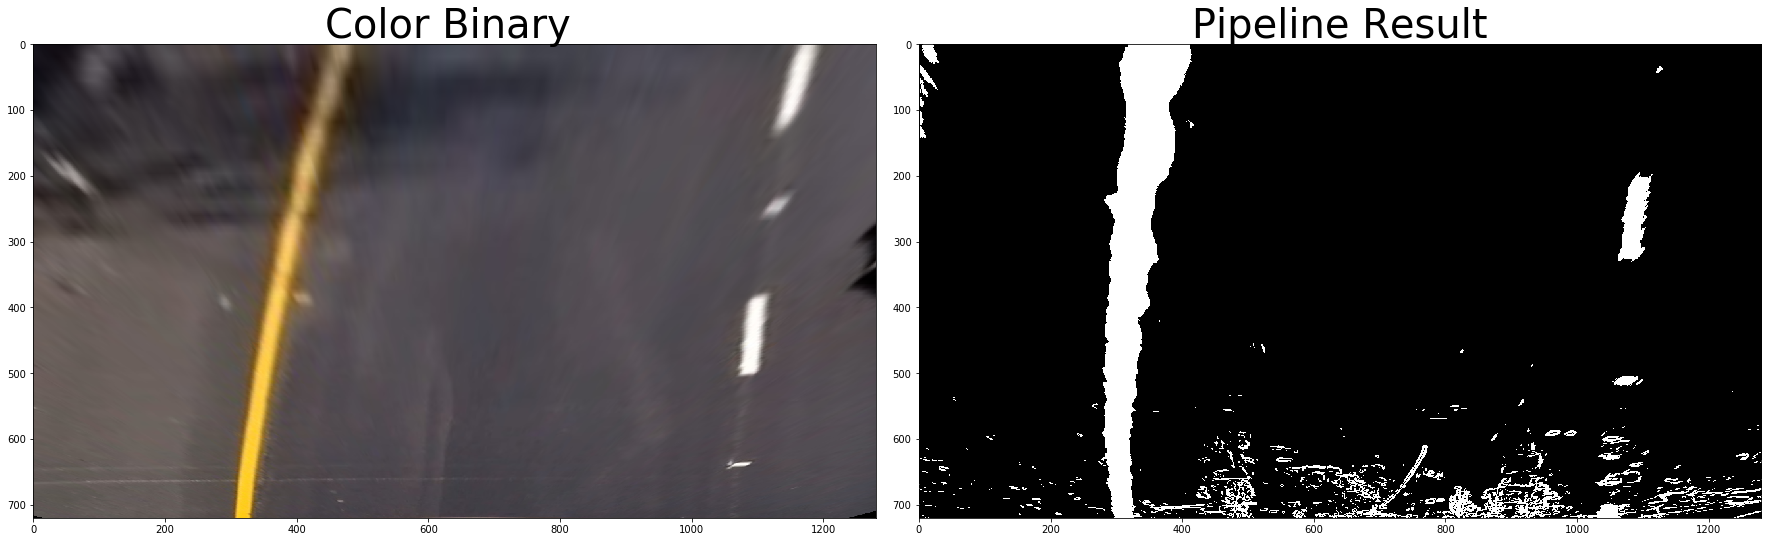

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(top_down)
ax1.set_title('Color Binary ', fontsize=40)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Run pipeline on all test images

In [54]:
#images_color_binary = []
images_combined_binary = []

for image, index in zip(testImages, range(len(testImages))):
    image_to_process = mpimg.imread(image)
    #color_binary, combined_binary = pipeline(image_to_process)
    combined_binary1 = pipeline(image_to_process)
    #images_color_binary.append(color_binary)
    images_combined_binary.append(combined_binary1)
    
    # Save the images to folder
    
    mpimg.imsave(( (testImages[index]).split('/')[0]+ '/' + 'combined_binary_' + (testImages[index]).split('/')[1] ), combined_binary1, cmap='gray')

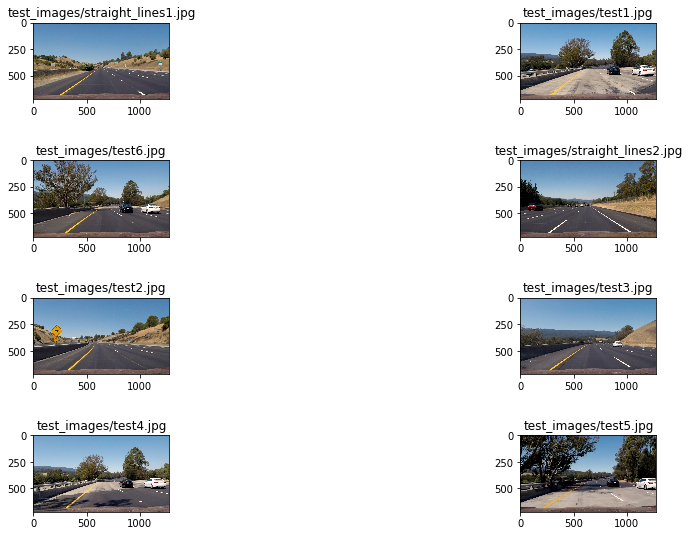

In [55]:
displayImages(testImages, cols = 2, rows = 4)

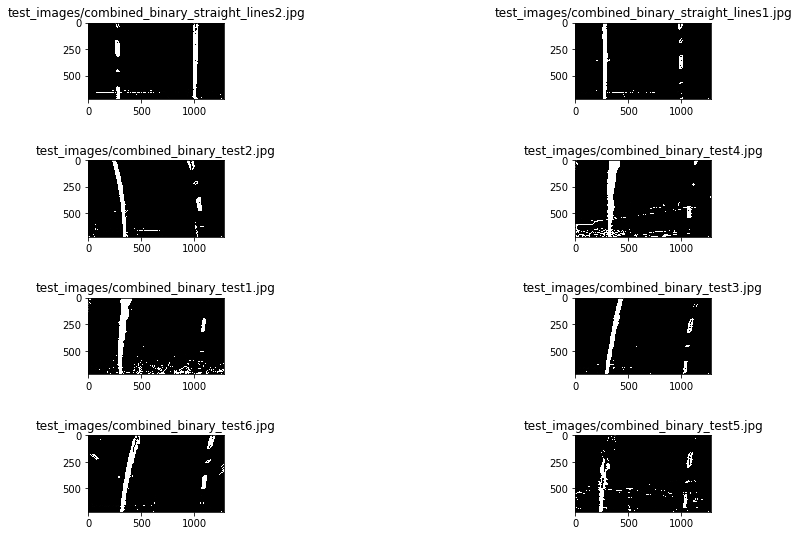

In [56]:
combined_binaries = glob.glob('test_images/combined*.jpg')

displayImages(combined_binaries, cols = 2, rows = 4)

# Step 5: Detect lane pixels and fit to find the lane boundary.

1280


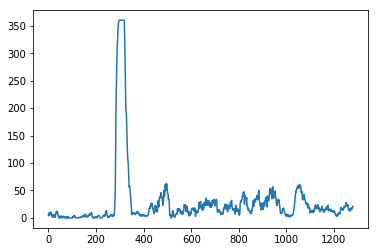

In [57]:
histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)
print(len(histogram))

## Define a class to receive the characteristics of each line detection

In [58]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #polynomial coefficients for the most recent fit
        self.current_fit_cr = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature_p = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature_m = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [59]:
left_lane_line = Line()
right_lane_line = Line()

## Implementing sliding window and fitting polynomial

In [60]:
def findLanes(combined_binary, left_lane_line, right_line_line, nwindows = 9, margin = 100, minpix = 50, ym_per_pix = 30/720, xm_per_pix = 3.7/700):
    """
    Find the polynomial representation of the lanes using;
    
    - image: Image to find the lines on
    - nwindows: The number of windows along the lanes through the height of the image
    - margin: The windows margin.
    - minpix: Minimum number of pixes found to recenter the window.
    - `ym_per_pix` meters per pixel on Y.
    - `xm_per_pix` meters per pixels on X.
    
    Returns (left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)
    """ 
    

    #print("Lane Detected status for left Lane: ", left_lane_line.detected)
    #print("Lane Detected status for right Lane: ", right_lane_line.detected)
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # Set height of windows
    window_height = np.int(combined_binary.shape[0]//nwindows)
    
    if not left_lane_line.detected or not right_lane_line.detected:
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = combined_binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set the width of the windows +/- margin
        margin = margin

        # Set minimum number of pixels found to recenter window
        minpix = minpix

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = combined_binary.shape[0] - (window+1)*window_height
            win_y_high = combined_binary.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Fit a second order polynomial to each
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Generate x and y values for plotting

        ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        #print(left_fitx.shape)
        #print(right_fitx.shape)
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        #Assign the values to left lane and right lane lines and return them

        # Determine if left line found
        if left_fitx.all():
            left_lane_line.detected = True



        # Current x fit and best x fit for left lane
        left_lane_line.recent_xfitted = left_fitx
        left_lane_line.bestx = np.mean(left_lane_line.recent_xfitted)

        # Current coefficients and best (mean) coefficients for left lane
        left_lane_line.current_fit = left_fit
        left_lane_line.best_fit = np.mean(left_lane_line.current_fit)
        left_lane_line.current_fit_cr = left_fit_cr


        # Current positions for left lane
        left_lane_line.line_base_position = leftx_current

        # x, y values for left lane
        left_lane_line.allx = leftx
        left_lane_line.ally = lefty

        # Determine if right line found
        if right_fitx.all():
            right_lane_line.detected = True

        # Current x fit and best x fit for right lane
        right_lane_line.recent_xfitted = right_fitx
        right_lane_line.bestx = np.mean(right_lane_line.recent_xfitted)

        # Current coefficients and best (mean) coefficients for right lane
        right_lane_line.current_fit = right_fit
        right_lane_line.best_fit = np.mean(right_lane_line.current_fit)
        right_lane_line.current_fit_cr = right_fit_cr


        # Current positions for right lane
        right_lane_line.line_base_position = rightx_current

        # x, y values for right lane
        right_lane_line.allx = rightx
        right_lane_line.ally = righty
    else:
        nonzero = combined_binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        margin = margin
        
        left_fit = left_lane_line.current_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_fit = right_lane_line.current_fit
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Fit a second order polynomial to each
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        # Determine if left line found
        if left_fitx.all():
            left_lane_line.detected = True



        # Current x fit and best x fit for left lane
        left_lane_line.recent_xfitted = left_fitx
        left_lane_line.bestx = np.mean(left_lane_line.recent_xfitted)

        # Current coefficients and best (mean) coefficients for left lane
        left_lane_line.current_fit = left_fit
        left_lane_line.best_fit = np.mean(left_lane_line.current_fit)
        left_lane_line.current_fit_cr = left_fit_cr


        # x, y values for left lane
        left_lane_line.allx = leftx
        left_lane_line.ally = lefty

        # Determine if right line found
        if right_fitx.all():
            right_lane_line.detected = True

        # Current x fit and best x fit for right lane
        right_lane_line.recent_xfitted = right_fitx
        right_lane_line.bestx = np.mean(right_lane_line.recent_xfitted)

        # Current coefficients and best (mean) coefficients for right lane
        right_lane_line.current_fit = right_fit
        right_lane_line.best_fit = np.mean(right_lane_line.current_fit)
        right_lane_line.current_fit_cr = right_fit_cr


        # x, y values for right lane
        right_lane_line.allx = rightx
        right_lane_line.ally = righty
    #print("left_fit_cr", left_lane_line.current_fit_cr, "right_fit_cr: ", right_lane_line.current_fit_cr)
    return out_img, left_lane_line, right_lane_line

In [61]:
LEFT = Line()
RIGHT = Line()

lanes_found_image, LEFT, RIGHT = findLanes(combined_binary, LEFT, RIGHT)

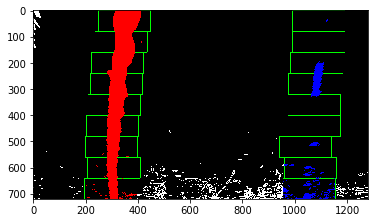

In [62]:
plt.imshow(lanes_found_image)

(720, 0)

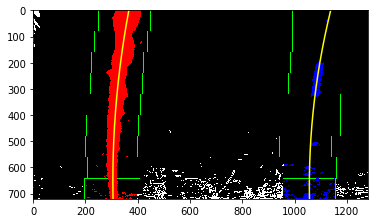

In [63]:
# Generate x and y values for plotting

ploty = np.linspace(0, lanes_found_image.shape[0]-1, lanes_found_image.shape[0] )
plt.imshow(lanes_found_image)
plt.plot(LEFT.recent_xfitted, ploty, color='yellow')
plt.plot(RIGHT.recent_xfitted, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [64]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
y_eval = np.max(ploty)

# Define conversions in x and y from pixels space to meters

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

## Step 6: Determine the curvature of the lane and vehicle position with respect to center.

In [65]:
def rocLane(Lane, yvalue, ym_per_pix = 30/720):
    '''
    Calculates the radius of a lane and returns values in both pixels and meters
    '''
    fit = np.polyfit(Lane.ally, Lane.allx, 2)
    
    radius_in_pixels = ((1 + (2 * fit[0] * yvalue + \
                        fit[1])**2)**1.5) / np.absolute(2*fit[0])

    
    fit_cr = Lane.current_fit_cr

    radius_in_meters = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + \
                        fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    return radius_in_pixels, radius_in_meters

In [66]:
LEFT.radius_of_curvature_p, LEFT.radius_of_curvature_m = rocLane(LEFT, y_eval)
RIGHT.radius_of_curvature_p, RIGHT.radius_of_curvature_m = rocLane(RIGHT, y_eval)

print(LEFT.radius_of_curvature_p, RIGHT.radius_of_curvature_p)
print(LEFT.radius_of_curvature_m, RIGHT.radius_of_curvature_m)

3493.65086782 2752.16726956
1146.88656297 903.523620187


In [67]:
# Calculate Vehicle position with respect to center

def vehicle_position(image, LEFT, RIGHT):
    x_max_in_meters = image.shape[1] * xm_per_pix
    y_max_in_meters = image.shape[0] * ym_per_pix
    
    vehicle_center = x_max_in_meters/2
    lift_line = LEFT.current_fit_cr[0] * y_max_in_meters**2 + \
                LEFT.current_fit_cr[1] * y_max_in_meters + \
                LEFT.current_fit_cr[2]
    
    right_line = RIGHT.current_fit_cr[0] * y_max_in_meters**2 + \
                RIGHT.current_fit_cr[1] * y_max_in_meters + \
                RIGHT.current_fit_cr[2]
    
    middle_line = lift_line + (right_line - lift_line)/2
    position = middle_line - vehicle_center 
    
    return position

In [68]:
position = vehicle_position(lanes_found_image, LEFT, RIGHT)

print(position)

0.217672957979


## Step 7: Warp the detected lane boundaries back onto the original image and visual display of the lane boundaries

In [69]:
def drawLane(original_image,warped_binary, left, right, Minv):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
   
    left_fit = np.polyfit(left.ally, left.allx, 2)
    right_fit = np.polyfit(right.ally, right.allx, 2)
    #print(left_fit)
    #print(right_fit)
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)

In [70]:
lane = drawLane(test_image, combined_binary, LEFT, RIGHT, Minv)

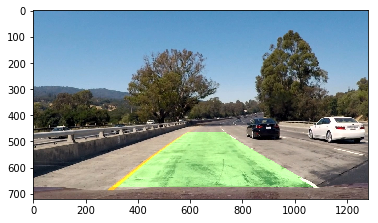

In [71]:
plt.imshow(lane)

## Step 8: Output numerical estimation of lane curvature and vehicle position.

In [72]:
def annotate(img, LEFT, RIGHT, position):
    image_to_annotate = np.copy(img)
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    if position > 0:
        message = '{:.3f} m right'.format(position)
    else:
        message = '{:.3f} m left'.format(-position)
    
    cv2.putText(image_to_annotate, 'Left lane RoC: {0:6f} m'.format(LEFT.radius_of_curvature_m), (0,50), font, 2, (255,255,255), 2)
    cv2.putText(image_to_annotate, 'Right lane RoC: {0:6f} m'.format(RIGHT.radius_of_curvature_m),(0,100), font,2, (255,255,255), 2)
    cv2.putText(image_to_annotate, 'Vehicle is {} of center'.format(message), (0,150), font, 2, (255,255,255), 2)
    
    return image_to_annotate

In [73]:
annotated_image = annotate(lane, LEFT, RIGHT, position)

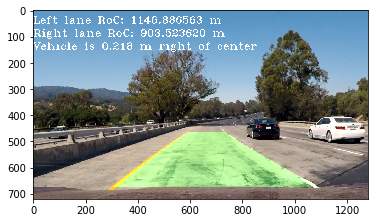

In [74]:
plt.imshow(annotated_image)

### Test all the steps before writing a function

In [75]:

# Read an image

test_image = mpimg.imread('test_images/test1.jpg')

# Step 2: Apply a distortion correction to raw images

undistorted_image = undistort(test_image, mtx, dist)

# Step 3: Apply a perspective transform to rectify binary image ("birds-eye view").

top_down, M, Minv = transform_and_warp(undistorted_image, src, dst)

# Step 4: Use color transforms, gradients, etc., to create a thresholded binary image.

combined_binary = makeBinary(top_down)

# Step 5: Detect lane pixels and fit to find the lane boundary.

LEFT = Line()
RIGHT = Line()

out_img, LEFT, RIGHT = findLanes(combined_binary, LEFT, RIGHT)

# Step 6: Determine the curvature of the lane and vehicle position with respect to center.    

LEFT.radius_of_curvature_p, LEFT.radius_of_curvature_m = rocLane(LEFT, y_eval)
RIGHT.radius_of_curvature_p, RIGHT.radius_of_curvature_m = rocLane(RIGHT, y_eval)

print(LEFT.radius_of_curvature_p, RIGHT.radius_of_curvature_p)
print(LEFT.radius_of_curvature_m, RIGHT.radius_of_curvature_m)

position = vehicle_position(lane, LEFT, RIGHT)

print(position)

# Step 7: Warp the detected lane boundaries back onto the original image and visual display of the lane boundaries

lane = drawLane(test_image, combined_binary, LEFT, RIGHT, Minv)

# Step 8: Output numerical estimation of lane curvature and vehicle position.  

annotated_image = annotate(lane, LEFT, RIGHT, position)



3493.65086782 2752.16726956
1146.88656297 903.523620187
0.217672957979


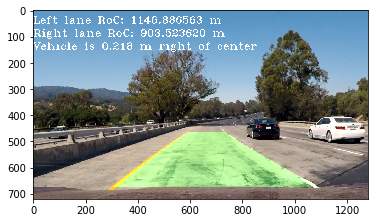

In [76]:
# Display the image

plt.imshow(annotated_image)

In [77]:
def process_image(image):
    # NOTE: The output you return should be a color image 
    # (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    left = Line()
    right = Line()
    
    test_image = np.copy(image)

    # Step 2: Apply a distortion correction to raw images
    undistorted_image = undistort(test_image, mtx, dist)

    # Step 3: Apply a perspective transform to rectify binary image ("birds-eye view").
    warped, M, Minv = transform_and_warp(undistorted_image, src, dst)
    
    # Step 4: Use color transforms, gradients, etc., to create a thresholded binary image.

    warped_binary = makeBinary(warped)

    # Step 5: Detect lane pixels and fit to find the lane boundary.

    out_img, left, right = findLanes(warped_binary, left, right)

    # Step 6: Determine the curvature of the lane and vehicle position with respect to center.    

    left.radius_of_curvature_p, left.radius_of_curvature_m = rocLane(left, y_eval)
    right.radius_of_curvature_p, right.radius_of_curvature_m = rocLane(right, y_eval)

    
    position = vehicle_position(out_img, left, right)

    # Step 7: Warp the detected lane boundaries back onto the original image and visual display of the lane boundaries

    lanned_image = drawLane(test_image, warped_binary, left, right, Minv)

    # Step 8: Output numerical estimation of lane curvature and vehicle position.  
    
    annotated_image = annotate(lanned_image, left, right, position)

    return annotated_image

In [78]:
final_image = process_image(test_image)

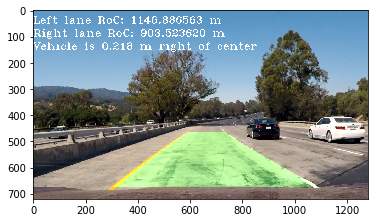

In [79]:
plt.imshow(final_image)

In [80]:
project_video_output = 'project_videos_output/project_video_after_process.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_videos_output/project_video_after_process.mp4
[MoviePy] Writing video project_videos_output/project_video_after_process.mp4


100%|█████████▉| 1260/1261 [04:13<00:00,  4.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_videos_output/project_video_after_process.mp4 

CPU times: user 44min 33s, sys: 30.9 s, total: 45min 4s
Wall time: 4min 14s


In [81]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

In [82]:
challenge_video_output = 'project_videos_output/harder_challenge_video_after_process.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_video_output, audio=False)




[MoviePy] >>>> Building video project_videos_output/harder_challenge_video_after_process.mp4
[MoviePy] Writing video project_videos_output/harder_challenge_video_after_process.mp4


100%|█████████▉| 1199/1200 [04:17<00:00,  4.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_videos_output/harder_challenge_video_after_process.mp4 

CPU times: user 42min 42s, sys: 37.6 s, total: 43min 19s
Wall time: 4min 18s


In [83]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))